# Data Loading

In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

print(df.shape)
df.head()

(569, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values # 유방암환자(M) / 정상인(B)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=1)

le = LabelEncoder()
y = le.fit_transform(y)
print(le.transform(['M','B']))

print(1 - y.mean())

[1 0]
0.6274165202108963


# Pipeline Streaming

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression # M or B
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=4),
    LogisticRegression(random_state=1, solver='lbfgs')
)

pipe_lr.fit(X_train, y_train)
# StandardScaler(fit -> transform) -> PCA(fit -> transform) -> Logistic(fit)

y_train_pred = pipe_lr.predict(X_train)
y_test_pred = pipe_lr.predict(X_test)

In [4]:
# Accuracy Score
print(pipe_lr.score(X_train, y_train))
print(pipe_lr.score(X_test, y_test))

0.967032967032967
0.956140350877193


# K Fold cross-validation

In [5]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    cv=10 # K=10
)
print(f'CV accuracy: {scores}')
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: [0.97826087 0.95652174 0.95652174 0.95652174 0.91304348 0.95555556
 0.97777778 0.97777778 1.         0.97777778]
CV accuracy: 0.965 +/- 0.022


# Bias-Variance trade-off 그래프로 확인하기

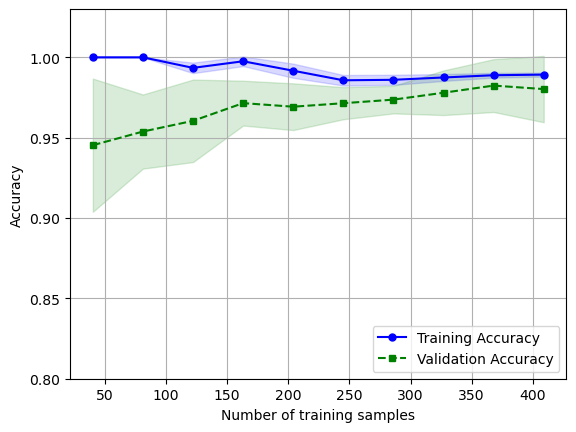

In [6]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2', random_state=1, solver='lbfgs')
) # L2 regularization

train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10
) # 569*0.8=455.2 -> 10개의 fold에 약 45개 표본 -> 각 fold에서 0.1,0.2,~1.0 비율로 표본 추출

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

# Grid search에 의한 초모수 결정

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(
    StandardScaler(),
    SVC(random_state=1))
param_range = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {'svc__C': param_range, 'svc__kernel': ['linear']},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}
]
gs = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
0.989010989010989
0.9736842105263158


# Nested Cross Validation

In [8]:
gs = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3
)

scores = cross_val_score(
    estimator=gs,
    X=X,
    y=y,
    scoring='accuracy',
    cv=5)

print('CV accuracy: %.8f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.97893184 +/- 0.007


# Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier

In [10]:
from sklearn.model_selection import KFold

inner_cv = KFold(
    n_splits=3,
    shuffle=True,
    random_state=1
)
outer_cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=1
)

tree = DecisionTreeClassifier(random_state=1)
gs = GridSearchCV(
    estimator=tree,
    param_grid=[
        {'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}
    ],
    scoring='accuracy',
    cv=inner_cv # inner loop: Tune parameters
)
scores = cross_val_score(
    estimator=gs,
    X=X, y=y,
    scoring='accuracy',
    cv=outer_cv
)
print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV accuracy: 0.932 +/- 0.032


In [11]:
from sklearn.model_selection import StratifiedKFold

inner_cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=1
)
outer_cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=1
)

tree = DecisionTreeClassifier(random_state=1)
gs = GridSearchCV(
    estimator=tree,
    param_grid=[
        {'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}
    ],
    scoring='accuracy',
    cv=inner_cv # inner loop: Tune parameters
)
scores = cross_val_score(
    estimator=gs,
    X=X, y=y,
    scoring='accuracy',
    cv=outer_cv
)
print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV accuracy: 0.923 +/- 0.027
